## Train test split

In [4]:
import os
import shutil
import random
from tqdm import tqdm

# Paths
input_dir = "processed_footballers_updated"  # This is the dataset after augmentation
train_dir = "dataset/train"
test_dir = "dataset/test"

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split ratio
split_ratio = 0.8

# Process each player's folder
for player in tqdm(os.listdir(input_dir), desc="Splitting Data"):
    player_path = os.path.join(input_dir, player)
    
    if not os.path.isdir(player_path):
        continue

    # Create player directories in train & test
    train_player_path = os.path.join(train_dir, player)
    test_player_path = os.path.join(test_dir, player)
    os.makedirs(train_player_path, exist_ok=True)
    os.makedirs(test_player_path, exist_ok=True)

    # Get all images and shuffle
    images = os.listdir(player_path)
    random.shuffle(images)

    # Split data
    split_idx = int(len(images) * split_ratio)
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Copy images to respective folders
    for img in train_images:
        shutil.copy(os.path.join(player_path, img), os.path.join(train_player_path, img))
    
    for img in test_images:
        shutil.copy(os.path.join(player_path, img), os.path.join(test_player_path, img))


Splitting Data: 100%|██████████| 26/26 [00:01<00:00, 16.86it/s]


### Augment training set

In [5]:
import cv2
import albumentations as A

# Augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5),
])

# Apply augmentation
for player in tqdm(os.listdir(train_dir), desc="Augmenting Training Set"):
    player_train_path = os.path.join(train_dir, player)

    if not os.path.isdir(player_train_path):
        continue

    for img_name in os.listdir(player_train_path):
        img_path = os.path.join(player_train_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = augmentations(image=img_rgb)["image"]
        augmented_bgr = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)

        output_path = os.path.join(player_train_path, f"aug_{img_name}")
        cv2.imwrite(output_path, augmented_bgr)


Augmenting Training Set: 100%|██████████| 26/26 [00:04<00:00,  5.71it/s]


## create Embedding 

In [4]:
import os
import torch
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import cv2

# Initialize MTCNN for face detection and InceptionResnetV1 for face recognition
mtcnn = MTCNN(keep_all=True)
model = InceptionResnetV1(pretrained='vggface2').eval()

# Path to the augmented images
input_dir = "dataset/test"
output_dir = "embeddings_test"

# Create output directory for storing embeddings
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to get embeddings for an image
def get_embeddings(image_path):
    img = Image.open(image_path)
    img_cropped = mtcnn(img)  # Detect faces

    if img_cropped is not None:
        embeddings = model(img_cropped)  # Get embeddings
        return embeddings.detach().cpu().numpy()
    return None

# Process each player's folder
for player in os.listdir(input_dir):
    player_input_path = os.path.join(input_dir, player)
    player_embedding_path = os.path.join(output_dir, player)

    # Create player's folder for embeddings
    if not os.path.exists(player_embedding_path):
        os.makedirs(player_embedding_path)

    # Process each augmented image
    for img_name in os.listdir(player_input_path):
        img_path = os.path.join(player_input_path, img_name)

        # Get embeddings
        embeddings = get_embeddings(img_path)
        if embeddings is not None:
            # Save embeddings as a .npy file
            np.save(os.path.join(player_embedding_path, f"{img_name.split('.')[0]}.npy"), embeddings)

print("Embeddings extraction completed and saved in 'embeddings'.")



Embeddings extraction completed and saved in 'embeddings'.


## Train Face-recognition Model

In [3]:
import os
import numpy as np

# Path to embeddings folder
embedding_dir = "embeddings_train"

X_train, y_train = [], []
player_labels_train = {}  # Mapping of player names to numerical labels

# Assign numerical labels to players
for idx, player in enumerate(sorted(os.listdir(embedding_dir))):  # Sort for consistency
    player_path = os.path.join(embedding_dir, player)
    
    if os.path.isdir(player_path):
        player_labels_train[player] = idx  # Assign an index to each player

        # Load all embeddings in the folder
        for file in os.listdir(player_path):
            if file.endswith(".npy"):
                embedding = np.load(os.path.join(player_path, file))

                # Ensure embedding is 1D (flatten if needed)
                if len(embedding.shape) > 1:  
                    embedding = embedding.reshape(-1)  # Flatten to 1D

                # Check if embedding has the correct size (512 for FaceNet)
                if embedding.shape[0] == 512:
                    X_train.append(embedding)
                    y_train.append(idx)  # Store numerical label

# Convert to NumPy arrays
X_train = np.array(X_train, dtype=np.float32)  # Ensure float32 for ML models
y_train = np.array(y_train, dtype=np.int32)    # Ensure int labels

# Print dataset shape
print("Shape of X:", X_train.shape)  # Should be (num_samples, 512)
print("Shape of y:", y_train.shape)  # Should be (num_samples,)
print("Player labels mapping:", player_labels_train)


Shape of X: (863, 512)
Shape of y: (863,)
Player labels mapping: {'Alexis_Mac_Allister': 0, 'Angel_di_maria': 1, 'Antoine_Griezmann': 2, 'Bernardo Silva': 3, 'Cristiano_Ronaldo': 4, 'Emiliano_martinez': 5, 'Erling Haaland': 6, 'Harry Kane': 7, 'Joshua_Kimmich': 8, 'Jude Bellingham': 9, 'Julian_Alvarez': 10, 'Karim_Benzema': 11, 'Kevin De Bruyne': 12, 'Kylian Mbappe': 13, 'Lautaro_Martinez': 14, 'Lionel Messi': 15, 'Luka_Modric': 16, 'Mohamed Salah': 17, 'Neymar_Jr': 18, 'Robert_Lewandowski': 19, 'Rodri': 20, 'Rodrigo_De_Paul': 21, 'Sadio_Mane': 22, 'Thibaut_Courtois': 23, 'Vinicius Junior': 24, 'Virgil_van_Dijk': 25}


In [4]:
import os
import numpy as np

# Path to embeddings folder
embedding_dir = "embeddings_test"

X_test, y_test = [], []
player_labels_test = {}  # Mapping of player names to numerical labels

# Assign numerical labels to players
for idx, player in enumerate(sorted(os.listdir(embedding_dir))):  # Sort for consistency
    player_path = os.path.join(embedding_dir, player)
    
    if os.path.isdir(player_path):
        player_labels_test[player] = idx  # Assign an index to each player

        # Load all embeddings in the folder
        for file in os.listdir(player_path):
            if file.endswith(".npy"):
                embedding = np.load(os.path.join(player_path, file))

                # Ensure embedding is 1D (flatten if needed)
                if len(embedding.shape) > 1:  
                    embedding = embedding.reshape(-1)  # Flatten to 1D

                # Check if embedding has the correct size (512 for FaceNet)
                if embedding.shape[0] == 512:
                    X_test.append(embedding)
                    y_test.append(idx)  # Store numerical label

# Convert to NumPy arrays
X_test = np.array(X_test, dtype=np.float32)  # Ensure float32 for ML models
y_test = np.array(y_test, dtype=np.int32)    # Ensure int labels

# Print dataset shape
print("Shape of X:", X_test.shape)  # Should be (num_samples, 512)
print("Shape of y:", y_test.shape)  # Should be (num_samples,)
print("Player labels mapping:", player_labels_test)


Shape of X: (124, 512)
Shape of y: (124,)
Player labels mapping: {'Alexis_Mac_Allister': 0, 'Angel_di_maria': 1, 'Antoine_Griezmann': 2, 'Bernardo Silva': 3, 'Cristiano_Ronaldo': 4, 'Emiliano_martinez': 5, 'Erling Haaland': 6, 'Harry Kane': 7, 'Joshua_Kimmich': 8, 'Jude Bellingham': 9, 'Julian_Alvarez': 10, 'Karim_Benzema': 11, 'Kevin De Bruyne': 12, 'Kylian Mbappe': 13, 'Lautaro_Martinez': 14, 'Lionel Messi': 15, 'Luka_Modric': 16, 'Mohamed Salah': 17, 'Neymar_Jr': 18, 'Robert_Lewandowski': 19, 'Rodri': 20, 'Rodrigo_De_Paul': 21, 'Sadio_Mane': 22, 'Thibaut_Courtois': 23, 'Vinicius Junior': 24, 'Virgil_van_Dijk': 25}


In [5]:
# Reshape X to have the correct shape (samples, features)
X_train = X_train.reshape(X_train.shape[0], -1)  # (num_samples, 512)


In [6]:
import joblib
from sklearn.preprocessing import LabelEncoder

# Your dictionary of player names and labels
player_dict = {
    'Alexis_Mac_Allister': 0, 'Angel_di_maria': 1, 'Antoine_Griezmann': 2, 'Bernardo Silva': 3,
    'Cristiano_Ronaldo': 4, 'Emiliano_martinez': 5, 'Erling Haaland': 6, 'Harry Kane': 7,
    'Joshua_Kimmich': 8, 'Jude Bellingham': 9, 'Julian_Alvarez': 10, 'Karim_Benzema': 11,
    'Kevin De Bruyne': 12, 'Kylian Mbappe': 13, 'Lautaro_Martinez': 14, 'Lionel Messi': 15,
    'Luka_Modric': 16, 'Mohamed Salah': 17, 'Neymar_Jr': 18, 'Robert_Lewandowski': 19,
    'Rodri': 20, 'Rodrigo_De_Paul': 21, 'Sadio_Mane': 22, 'Thibaut_Courtois': 23,
    'Vinicius Junior': 24, 'Virgil_van_Dijk': 25
}

# Create LabelEncoder instance
label_encoder = LabelEncoder()

# Fit encoder with player names (keys of dictionary)
label_encoder.fit(list(player_dict.keys()))

# Save the label encoder
joblib.dump(label_encoder, "player_labels.pkl")

print("Label encoder saved successfully!")


Label encoder saved successfully!


In [24]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,  # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Restore model to best weights
)

model = models.Sequential([
    layers.Input(shape=(512,)),  # Input shape should be (512,)
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(26, activation="softmax")  # Output layer
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [25]:
model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Add callback
)


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2408 - loss: 3.1609 - val_accuracy: 0.6210 - val_loss: 2.5494
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6616 - loss: 2.1193 - val_accuracy: 0.7903 - val_loss: 1.2565
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8012 - loss: 1.0752 - val_accuracy: 0.8387 - val_loss: 0.7143
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8912 - loss: 0.5409 - val_accuracy: 0.8548 - val_loss: 0.5435
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9250 - loss: 0.3833 - val_accuracy: 0.8871 - val_loss: 0.4897
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9410 - loss: 0.2919 - val_accuracy: 0.8952 - val_loss: 0.4505
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9568 - loss: 0.2159 - val_accuracy: 0.8952 - val_loss: 0.4512
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9650 - loss: 0.1929 - val_accuracy: 0.8952 - val_loss

In [26]:
model.save("face_recognition_model_updated.h5")


In [33]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes=y_pred.argmax(axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [34]:
y_test.shape

(124,)

In [36]:
y_pred_classes.shape

(124,)

In [38]:
y_pred_classes[1]

0

In [39]:
y_test[1]

0

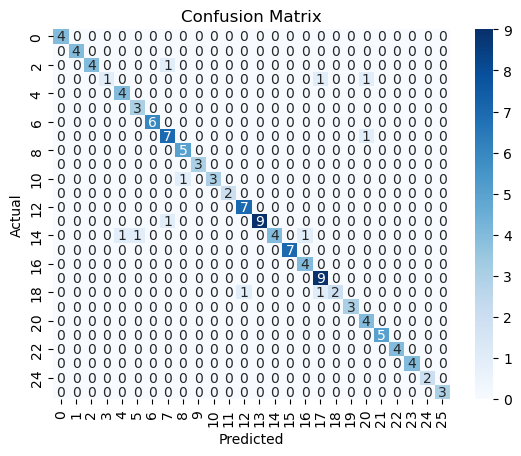

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      0.80      0.89         5
           3       1.00      0.33      0.50         3
           4       0.80      1.00      0.89         4
           5       0.75      1.00      0.86         3
           6       1.00      1.00      1.00         6
           7       0.78      0.88      0.82         8
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         3
          10       1.00      0.75      0.86         4
          11       1.00      1.00      1.00         2
          12       0.88      1.00      0.93         7
          13       1.00      0.90      0.95        10
          14       1.00      0.57      0.73         7
          15       1.00      1.00      1.00         7
          16       0.80      1.00      0.89         4
          17       0.82    

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# # Convert predictions to class labels
# y_pred_classes = y_pred.argmax(axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes))
